In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
np.random.seed(1)

In [2]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
Y_train_orig = np.load('Y_train.npy')
Y_train_orig = Y_train_orig.reshape((Y_train_orig.shape[0],1))
Y_test_orig = np.load('Y_test.npy')
Y_test_orig = Y_test_orig.reshape((Y_test_orig.shape[0],1))

In [3]:
la = LabelEncoder()
la.fit(Y_train_orig)
Y_train_la = la.transform(Y_train_orig)
Y_test_la = la.transform(Y_test_orig)

/home/mrityunjay/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mrityunjay/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
n_classes = 29
Y_train = np.eye(n_classes)[Y_train_la]
Y_test = np.eye(n_classes)[Y_test_la]

y =  G


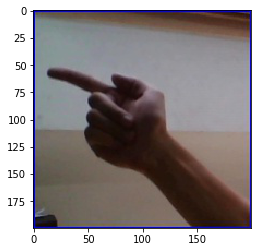

In [5]:
plt.imshow(X_train[25])
print('y = ',la.inverse_transform(Y_train_la)[25])

In [6]:
print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('Y_train shape : ',Y_train.shape)
print('Y_test shape : ',Y_test.shape)

X_train shape :  (696, 200, 200, 3)
X_test shape :  (28, 200, 200, 3)
Y_train shape :  (696, 29)
Y_test shape :  (28, 29)


In [7]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    
    X = tf.placeholder(dtype=tf.float32, shape=[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(dtype=tf.float32, shape=[None, n_y])
    
    return X, Y

In [8]:
def initialize_parameters():
    
    tf.set_random_seed(1)

    W1 = tf.get_variable('W1', [4,4,3,8], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable('W2', [2,2,8,16], initializer = tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [9]:
def forward_propagation(X, parameters):

    W1 = parameters['W1']
    W2 = parameters['W2']

    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')

    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')

    P2 = tf.contrib.layers.flatten(P2) 
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs = 29, activation_fn = None)

    return Z3

In [10]:
def compute_cost(Z3, Y):    
    
    cost = tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y)
    
    return tf.reduce_mean(cost)

In [11]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    np.random.seed(seed)
    m = X.shape[0]
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):

        mini_batch_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,k*(m%mini_batch_size):(k+1)*(m%mini_batch_size)]
        mini_batch_Y = shuffled_Y[:,k*(m%mini_batch_size):(k+1)*(m%mini_batch_size)]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [13]:
def model(X_train, Y_train, X_test, Y_test, 
          learning_rate = 0.01,
          num_epochs = 100, 
          print_cost = True):
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    #print(n_y)
    costs = []
    

    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    parameters = initialize_parameters()

    Z3 = forward_propagation(X, parameters)

    cost = compute_cost(Z3, Y)

    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        costs = []
        for epoch in range(num_epochs):
            _ , temp_cost = sess.run([optimizer, cost], feed_dict = {X: X_train, Y: Y_train})
            costs.append(temp_cost)

            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch {}: {}".format(epoch, temp_cost))

        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()

        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        #print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 3.4035069942474365
Cost after epoch 5: 2.9138286113739014
Cost after epoch 10: 0.9075457453727722
Cost after epoch 15: 0.1652427315711975
Cost after epoch 20: 0.05643213167786598
Cost after epoch 25: 0.01541015226393938
Cost after epoch 30: 0.004011695738881826
Cost after epoch 35: 0.005117983557283878
Cost after epoch 40: 0.0022855731658637524
Cost after epoch 45: 0.0011890257010236382
Cost after epoch 50: 0.0008658

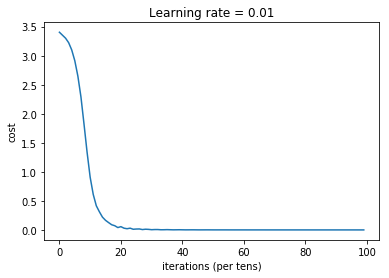

Train Accuracy: 1.0
Test Accuracy: 0.96428573


In [14]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

In [15]:
def predict(X_test, parameters):
    tf.set_random_seed(1)
    Z3 = forward_propagation(X_test, parameters)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        predict_op = tf.argmax(Z3, 1)
        index = sess.run(predict_op)[0]
        print('y =', la.inverse_transform(Y_test_la)[index])
    return predict_op

Shape of image : (200, 200, 3)


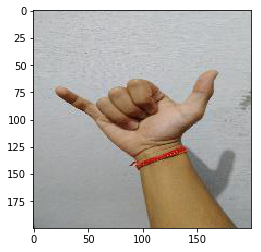

In [18]:
fname = "Y.jpg"
img = Image.open(fname)
img_ = img.rotate(270)
print('Shape of image :', np.asarray(img_).shape)
plt.imshow(img_)

In [19]:
x_test_single = np.asarray(img_)/255.0
x_test_single = x_test_single.astype(np.float32)
x_test_single = x_test_single.reshape(1, *x_test_single.shape)

In [20]:
y_pred = predict(x_test_single, parameters)

y = D
